In [168]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# !pip install pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Load data

In [170]:
class Dataset_torch(Dataset):

    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data['y'])    

    def __getitem__(self, idx):
        
        inputs = [self.data['x1'][idx],self.data['x2'][idx].float()]
        return inputs, self.data['y'][idx]
        

In [171]:
data_18 = torch.load('/content/drive/MyDrive/sar_img/dataset/tensors_2018.pt')
dataset_2018 = Dataset_torch(data_18)
data_loader_2018 = torch.utils.data.DataLoader(dataset=dataset_2018, batch_size=1024,num_workers=2)

## Get index wrt ALT Hs with step 0.5

In [172]:
index_all = []
for i in range(22):
    index_all.append(torch.nonzero((data_18['y'][:,0] > i*0.5) & (data_18['y'][:,0] < (i+1)*0.5)))

# Get Hs from ALT

In [173]:
data_18_y = data_18['y'].to(device)[:,0]

In [ ]:
del data_18 # free RAM

# Model proposed

In [175]:
class Net_spectral(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        # self.conv4 = nn.Conv2d(256, 512, 3)

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)

        self.fc512_n1 = nn.Linear(256, 256)
        self.fc512_n2 = nn.Linear(256, 256)

    def forward(self, x):
        x = self.maxpooling2d(F.relu(self.conv1(x)))
        x = self.maxpooling2d(F.relu(self.conv2(x)))
        x = self.maxpooling2d(F.relu(self.conv3(x)))
        # x = self.maxpooling2d(F.relu(self.conv4(x)))
        x= self.globalmaxpooling2d(x)
        x = F.relu(self.fc512_n1(torch.squeeze(x)))

        x = F.relu(self.fc512_n2(x))
        x = self.dropout(x)
        return x

class MLP_output(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)
        self.dropout_n3 = nn.Dropout(p=0.5)


        self.fc256 = nn.Linear(256, 256)

        # self.fc1024_512 = nn.Linear(1024, 512)
        self.fc512_256 = nn.Linear(512, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_2 = nn.Linear(128,2)

    def forward(self, x):


        # x = F.relu(self.fc1024_512(x))
        # x = self.dropout_n1(x)
        # x = F.relu(self.fc512_256(x))
        # x = self.dropout_n2(x)
        x = F.relu(self.fc256_128(x))
        x = self.dropout_n3(x)

        output = F.softplus(self.fc128_2(x))

        return output



class Net_cwave(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim = 1)


        self.fc10_64 = nn.Linear(10, 64)
        self.fc64_128 = nn.Linear(64, 128)
        self.fc128_256 = nn.Linear(128, 256)
        self.fc256_512 = nn.Linear(256, 512)
        self.fc512_1024 = nn.Linear(512, 1024)
        self.fc1024_2048 = nn.Linear(1024,2048)

    def forward(self, x):
        x = F.relu(self.fc10_64(x[:,22:]))
        x = F.relu(self.fc64_128(x))
        x = F.relu(self.fc128_256(x))
        x = F.relu(self.fc256_512(x))
        x = F.relu(self.fc512_1024(x))
        x = F.relu(self.fc1024_2048(x))
        x = x.view(-1,8,256)

        x = self.softmax(x)
        x = self.dropout(x)
        return x

# combination of two NN
class Net_comb(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveMaxPool2d(1)

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)

        self.fc256 = nn.Linear(256, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_1 = nn.Linear(128, 1)

        self.net_cwave = Net_cwave()

        self.net_spectral_n1 = Net_spectral()
        self.net_spectral_n2 = Net_spectral()
        self.net_spectral_n3 = Net_spectral()
        self.net_spectral_n4 = Net_spectral()
        self.net_spectral_n5 = Net_spectral()
        self.net_spectral_n6 = Net_spectral()
        self.net_spectral_n7 = Net_spectral()
        self.net_spectral_n8 = Net_spectral()

        self.mlp_out = MLP_output()
        # self.mlp_out_2 = MLP_output()

    def forward(self, x1,x2):

        cnn_output_n1 = self.net_spectral_n1(x1)
        cnn_output_n2 = self.net_spectral_n2(x1)
        cnn_output_n3 = self.net_spectral_n3(x1)
        cnn_output_n4 = self.net_spectral_n4(x1)
        cnn_output_n5 = self.net_spectral_n5(x1)
        cnn_output_n6 = self.net_spectral_n6(x1)
        cnn_output_n7 = self.net_spectral_n7(x1)
        cnn_output_n8 = self.net_spectral_n8(x1)

        cnn_output_matrix = torch.cat([cnn_output_n1,cnn_output_n2,cnn_output_n3,cnn_output_n4,cnn_output_n5,cnn_output_n6,cnn_output_n7,cnn_output_n8],dim=1)
        cnn_output_matrix = cnn_output_matrix.view(-1,8,256)
        # print(self.net_cwave(x2).size())
        # print(cnn_output_matrix.size())
        x = cnn_output_matrix*self.net_cwave(x2)

        x = torch.sum(x,1)

        output = self.mlp_out(x)

        return output


    def training_step(self, batch, batch_idx):
        x, y_true = batch
        x1,x2 = x

        x1 = torch.cat([x1, torch.cat([torch.unsqueeze(x1[:,0,:,:],1),torch.unsqueeze(torch.zeros_like(x1[:,1,:,:]),1)],1)],0)
        x2 = torch.cat([x2,x2],0)

        y_pre = self.forward(x1,x2)


        loss_f = nn.GaussianNLLLoss()
        loss = loss_f(y_pre[:,0], torch.cat([torch.squeeze(y_true).float(),torch.squeeze(y_true).float()],0) ,y_pre[:,1])
        self.log('train_loss', loss)

        return loss



    def validation_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)

        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('val_loss', loss)
    
        return loss

    def test_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)
        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('test_loss', loss)
        
        return loss

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience= 1)

        return { 'optimizer': optimizer, 'lr_scheduler': { 'scheduler': scheduler, 'monitor': 'val_loss', } }

# Average six prediction of model proposed which are trained with fixed epochs (Data augmentation and attention network)

In [ ]:
class Net_comb_6(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.m1 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v1/lightning_logs/version_6/checkpoints/epoch=31-step=71199.ckpt')
        self.m2 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v1/lightning_logs/version_8/checkpoints/epoch=31-step=71199.ckpt')
        self.m3 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_0/checkpoints/epoch=31-step=71199.ckpt')
        self.m4 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_2/checkpoints/epoch=31-step=71199.ckpt')
        self.m5 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_3/checkpoints/epoch=31-step=71199.ckpt')
        self.m6 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_7/checkpoints/epoch=31-step=71199.ckpt')

    def forward(self, x1,x2):

        out = torch.cat([torch.unsqueeze(self.m1(x1,x2),2),torch.unsqueeze(self.m2(x1,x2),2),torch.unsqueeze(self.m3(x1,x2),2),torch.unsqueeze(self.m4(x1,x2),2),torch.unsqueeze(self.m5(x1,x2),2),torch.unsqueeze(self.m6(x1,x2),2)],2)
        out = torch.mean(out,2)


        return out

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        x1,x2 = x

        x1 = torch.cat([x1, torch.cat([torch.unsqueeze(x1[:,0,:,:],1),torch.unsqueeze(torch.zeros_like(x1[:,1,:,:]),1)],1)],0)
        x2 = torch.cat([x2,x2],0)

        y_pre = self.forward(x1,x2)


        loss_f = nn.GaussianNLLLoss()
        loss = loss_f(y_pre[:,0], torch.cat([torch.squeeze(y_true).float(),torch.squeeze(y_true).float()],0) ,y_pre[:,1])
        self.log('train_loss', loss)

        return loss



    def validation_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)

        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('val_loss', loss)
    
        return loss

    def test_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)
        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('test_loss', loss)
        
        return loss

    def predict_step(self, batch, batch_idx):
        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2)
        return y_pre

    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience= 4)

        return { 'optimizer': optimizer, 'lr_scheduler': { 'scheduler': scheduler, 'monitor': 'val_loss', } }
    

# Prediction

In [ ]:
model_6 = Net_comb_6()
trainer = pl.Trainer(gpus=1)
predict_2018_test_k8_avg6_aug_fix = trainer.predict(model=model_6,dataloaders = data_loader_2018)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [34]:
predict_2018_test_k8_avg6_aug_fix = torch.cat(predict_2018_test_k8_avg6_aug_fix)
torch.save(predict_2018_test_k8_avg6_aug_fix, '/content/drive/MyDrive/sar_img/dataset/predict_2018_test_k8_avg6_aug_fix.pt')

In [176]:
predict_2018_test_k8_avg6_aug_fix = torch.load('/content/drive/MyDrive/sar_img/dataset/predict_2018_test_k8_avg6_aug_fix.pt',map_location=torch.device('cpu'))

# Compute MSE of proposed model

In [177]:
mse_all = []
for i in range(22):
    mse_all.append(F.mse_loss( predict_2018_test_k8_avg6_aug_fix[index_all[i]][:,0,0],data_18_y[index_all[i]][:,0]))

In [178]:
mse_all = np.array([mse.item() for mse in mse_all])
mse_all

array([0.53187186, 0.12454281, 0.04547141, 0.03533175, 0.04739319,
       0.07038735, 0.09793201, 0.12298181, 0.14684632, 0.18339487,
       0.2084623 , 0.22822303, 0.30917461, 0.40638516, 0.42082538,
       0.66062497, 0.70898745, 0.80733592, 1.14699545, 1.09437573,
       1.06864894, 1.35918206])

# Compute STD of proposed model

In [179]:
def compute_std(y_hat,y_true,mse):
  up_term = torch.sum( torch.square( torch.abs(y_hat-y_true) -mse ) )
  return torch.sqrt(up_term/(len(y_true)-1))

In [180]:
list_std = []
for i in range(22):
  list_std.append(compute_std(predict_2018_test_k8_avg6_aug_fix[:,0][index_all[i]],data_18_y[index_all[i]],mse_all[i]))

In [181]:
std_best = np.array([std.item() for std in list_std])
std_best

array([0.38138552, 0.25674136, 0.18182988, 0.16447984, 0.18624936,
       0.22042753, 0.25206541, 0.27581447, 0.29609069, 0.32472123,
       0.33891962, 0.34709503, 0.39319182, 0.44395385, 0.43769877,
       0.54079872, 0.55255211, 0.59329293, 0.72004253, 0.74749207,
       0.71804745, 0.68437086])

# Prediction of Hawaiian model

In [182]:
import sys
sys.path.append('/content/drive/MyDrive/sar_img/SAR-Wave-Height')

from tensorflow.keras.models import load_model
import keras

from sarhs.generator import SARGenerator
from sarhs.heteroskedastic import Gaussian_NLL, Gaussian_MSE


In [53]:
file_model = '/content/drive/MyDrive/sar_img/SAR-Wave-Height/models/heteroskedastic_2017.h5'
custom_objects = {'Gaussian_NLL':Gaussian_NLL, 'Gaussian_MSE':Gaussian_MSE}
model = load_model(file_model, custom_objects=custom_objects)

In [54]:
filename = '/content/drive/MyDrive/sar_img/dataset/aggregated_grouped_final.h5'
test = SARGenerator(filename=filename, 
                     subgroups=['2018'], 
                     batch_size=1024)


In [55]:
predict_2018_original_karas = model.predict(test)

In [57]:
np.save('/content/drive/MyDrive/sar_img/dataset/predict_2018_original_karas', predict_2018_original_karas)

In [183]:
predict_2018_original_karas = np.load('/content/drive/MyDrive/sar_img/dataset/predict_2018_original_karas.npy')

# Compute MSE of Hawaiian model

In [184]:
mse_all_keras = []
for i in range(22):
    mse_all_keras.append(F.mse_loss( torch.tensor(predict_2018_original_karas[index_all[i]][:,0,0]), torch.tensor(data_18_y.numpy()[index_all[i]][:,0])))

In [185]:
mse_all_keras = np.array([mse.item() for mse in mse_all_keras])
mse_all_keras

array([0.76144012, 0.22804826, 0.08137826, 0.05065595, 0.0592405 ,
       0.08194562, 0.11086507, 0.14025721, 0.17046908, 0.20742068,
       0.24115347, 0.28746568, 0.3783706 , 0.47789989, 0.52633776,
       0.86976703, 0.89072915, 1.16020279, 1.53541492, 1.58776032,
       1.7551292 , 2.25546944])

# Compute STD of Hawaiian model

In [186]:
def compute_std(y_hat,y_true,mse):
  up_term = torch.sum( torch.square( torch.abs(y_hat-y_true) -mse ) )
  return torch.sqrt(up_term/(len(y_true)-1))

list_std_keras = []
for i in range(22):
  list_std_keras.append(compute_std(torch.tensor(predict_2018_original_karas[index_all[i]][:,0])[:,0],data_18_y[index_all[i]][:,0],mse_all[i]))



In [187]:
std_keras = np.array([std.item() for std in list_std_keras])
std_keras

array([0.46909515, 0.37194675, 0.25084406, 0.20121169, 0.2112496 ,
       0.23986472, 0.26956939, 0.29517338, 0.31954186, 0.34286918,
       0.36427312, 0.39295203, 0.43239949, 0.4738849 , 0.47958597,
       0.58532468, 0.60213663, 0.63545157, 0.76737118, 0.7453524 ,
       0.69090822, 0.84582854])

# Plot MSE&STD

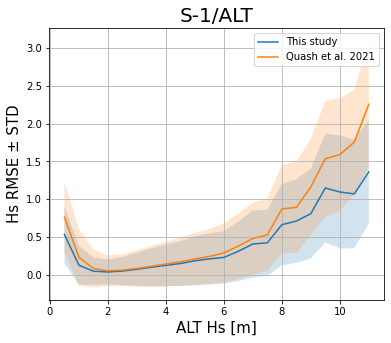

In [188]:
plt.figure(figsize=(6, 5))
plt.plot(np.arange(1,23)*0.5, mse_all, '-',label='This study')
plt.plot(np.arange(1,23)*0.5, mse_all_keras, '-',label='Quash et al. 2021')
plt.fill_between(np.arange(1,23)*0.5, np.array(mse_all) - np.array(std_best),  np.array(mse_all) + np.array(std_best), alpha=0.2)
plt.fill_between(np.arange(1,23)*0.5, np.array(mse_all_keras) - np.array(std_keras),  np.array(mse_all_keras) + np.array(std_keras), alpha=0.2)
plt.title('S-1/ALT', fontsize=20)

plt.ylabel('Hs RMSE ± STD', fontsize=15)
plt.xlabel('ALT Hs [m]', fontsize=15)
plt.grid()
plt.legend(fontsize=10)